In [ ]:
!pip install decompose
!pip install yfinance
!pip install yahoofinancials

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 164 kB 12.0 MB/s 
     |████████████████████████████████| 15.5 MB 64.4 MB/s 
     |████████████████████████████████| 843 kB 45.2 MB/s 
  Created wheel for decompose: filename=decompose-0.1-py3-none-any.whl size=196916 sha256=eb6eb63eb2b7c8a68a84608085cc24c09dae9432c980a8a2ade4e1a356f3b4ec
  Stored in directory: /root/.cache/pip/wheels/24/39/3b/ec7da9e2e52b4b1d0f4ef2cf8fe18ce06efef0e49b25502308
Successfully built decompose
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel fo

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from yahoofinancials import YahooFinancials
import plotly.graph_objects as go
import decompose
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
apple_df = yf.download('AAPL',start= '2017-01-01',progress=False)
apple_df.index=pd.to_datetime(apple_df.index)
apple_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.174759,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.144342,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.282381,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.586527,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,27.839203,134247600
...,...,...,...,...,...,...
2022-11-07,137.110001,139.149994,135.669998,138.919998,138.919998,83374600
2022-11-08,140.410004,141.429993,137.490005,139.500000,139.500000,89908500
2022-11-09,138.500000,138.550003,134.589996,134.869995,134.869995,74917800


In [ ]:
df=apple_df[["Close","Volume"]]
df.head()

,Close,Volume
Date,,
2017-01-03,29.037500,115127600
2017-01-04,29.004999,84472400
2017-01-05,29.152500,88774400
2017-01-06,29.477501,127007600
2017-01-09,29.747499,134247600


In [ ]:
def buy_sell_MA(data, perc = 50):
  buy_sell = []
  buy_signal = []
  sell_signal = []
  flag = 42

    # 5 ,14 21 ün ortalamaları
  rolling_app5 = data["Close"].rolling(window=5).mean()
  rolling_app14 = data["Close"].rolling(window=14).mean()
  rolling_app21 = data["Close"].rolling(window=21).mean()

  MAs = pd.concat([data["Close"], rolling_app5, rolling_app14, rolling_app21], axis=1)
  MAs.columns = ['Close', 'short', 'mid', 'long']

  up = MAs[(np.array(MAs["short"] - MAs["mid"])>0) & (np.array(MAs["short"] - MAs["long"])>0)]
  down =MAs[(np.array(MAs["short"] - MAs["mid"])<0) & (np.array(MAs["short"] - MAs["long"])<0)]

  ups = np.percentile(np.array(up["short"] - up["mid"]),perc)
  downs = np.percentile(np.array(down["short"] - down["long"]),perc)

  for i in range(0,len(MAs)):
    if (MAs["short"][i] > MAs["mid"][i]+ups) & (MAs["short"][i] > MAs["long"][i]+ups):
      buy_signal.append(np.nan)
      if flag != 1:
        sell_signal.append(MAs["Close"][i])
        buy_sell.append(MAs["Close"][i])
        flag=1
      else:
        sell_signal.append(np.nan)
    elif(MAs["short"][i] < MAs["mid"][i]-downs) & (MAs["short"][i] < MAs["long"][i]-downs):
      sell_signal .append(np.nan)
      if flag != 0:
        buy_signal.append(MAs["Close"][i])
        buy_sell.append(-MAs["Close"][i])
        flag = 0
      else:
        buy_signal.append(np.nan)
    else:
      buy_sell.append(np.nan)
      sell_signal.append(np.nan)
      buy_signal.append(np.nan)
  operations = np.array(buy_sell)
  operations = operations[~np.isnan(operations)]
#alım ve satım değerlerini ayırıyoruz
  neg = 0
  pos = 0

  for i in range(len(operations)):
    if operations[i] < 0:
      neg = i
      break
  for i in range(1,len(operations)):
    if operations[-i] > 0:
      pos = i-1
      break
  operations = operations[neg: -pos]#nagatifle başlayıp bazitifle günü kapatıyoruz
  PL = np.sum(operations)#kar mı zarar mı ettik kontrol

  return (buy_signal, sell_signal, PL)

In [ ]:
opt = []

percentile = np.arange(10,91,5)

for i,j in enumerate(percentile):
  opt.append((percentile[i],buy_sell_MA(df, j)[2]))

opt = pd.DataFrame(opt)

opt.columns = ["Percentile", "Performance"]
opt = opt.sort_values(by = "Performance", ascending=False)

In [ ]:
RES=pd.DataFrame()
RES["Close"]=apple_df["Close"]
RES["BUY_MA"] = buy_sell_MA(df, opt["Percentile"].values[0])[0]
RES["SELL_MA"] = buy_sell_MA(df, opt["Percentile"].values[0])[1]
res_MA= buy_sell_MA(df, opt["Percentile"].values[0])[2]

BBs

In [ ]:
def buy_sell_BB(data):

  buy_sell = []
  buy_signal = []
  sell_signal = []
  flag = 42

  BBs = pd.DataFrame()

  BBs["close"] = data["Close"]
  #standart sapma ve ortalama güven aralığını verir.
  BBs["SMA"]= BBs["close"].rolling(window = 20).mean()
  BBs["STD"] = BBs["close"].rolling(window = 20).std()
  BBs["upper"] = BBs["SMA"] + BBs["STD"]*2
  BBs["lower"] = BBs["SMA"] - BBs["STD"]*2

  for i in range(0,len(BBs)):
    if (BBs["close"][i] > BBs["upper"][i]):
      buy_signal.append(np.nan)
      if flag != 1:
        sell_signal.append(BBs["close"][i])
        buy_sell.append(BBs["close"][i])
        flag = 1
      else:
        sell_signal.append(np.nan)
    elif (BBs["close"][i] < BBs["lower"][i]):
      sell_signal .append(np.nan)
      if flag !=0:
        buy_signal.append(BBs["close"][i])
        buy_sell.append(-BBs["close"][i])
        flag = 0
      else:
        buy_signal.append(np.nan)

    else:
      buy_sell.append(np.nan)
      sell_signal .append(np.nan)
      buy_signal.append(np.nan)

    operations = np.array(buy_sell)
    operations = operations[~np. isnan(operations)]

    neg = 0
    pos = 0

    for i in range(len(operations)):
      if operations[i] <0:
        neg = i
        break

    for i in range(1,len(operations)):
      if operations[-i] > 0:
        pos = i-1
        break
    operations = operations[neg:-pos]
    PL = np.sum(operations)

  return (buy_signal, sell_signal,PL)

In [ ]:
RES["BUY_BB"]=buy_sell_BB(df)[0]
RES["SELL_BB"]=buy_sell_BB(df)[1]
res_BB=buy_sell_BB(df)[2]

MACD

In [ ]:
def buy_sell_MD(data, opt = 50):
  buy_sell = []
  buy_signal = []
  sell_signal = []
  flag = 42

  MDs = pd.DataFrame()
  MDs["close"] = data["Close"]
  MDs["short"] = MDs["close"].ewm(span=12, adjust = False).mean()#üst hareketli ortalama son gözlemlere öncekilerden daha çok ağırlık veriyor.12 gün
  MDs["long"] = MDs["close"].ewm(span=26, adjust = False).mean()#26
  MDs["MACD"] = MDs["short"] - MDs["long"]#farkı
  MDs["signal"] = MDs["MACD"].ewm(span=9, adjust = False).mean()#9 gün

  up = MDs[(np.array(MDs["MACD"] - MDs["signal"])>0)]
  down = MDs[(np.array(MDs["MACD"] - MDs["signal"])<0)]
  ups= np.percentile(np.array(up["MACD"] - up["signal"]),opt)
  downs = np.percentile(np.array(down["MACD"] - down["signal"]),opt)
  for i in range(0,len(MDs)):
    if(MDs["MACD"][i] > MDs["signal"][i]+ups):
      buy_signal.append(np.nan)
      if flag != 1:
        sell_signal.append(MDs["close"][i])
        buy_sell.append(MDs["close"][i])
        flag = 1

      else:
        sell_signal.append(np.nan)
    elif (MDs["MACD"][i] < MDs["signal"][i]+downs):
      sell_signal.append(np.nan)
      if flag != 0:
        buy_signal.append(MDs["close"][i])
        buy_sell.append(-MDs["close"][i])
        flag = 0
      else:
        buy_signal .append(np.nan)
    else:
      buy_sell.append(np.nan)
      sell_signal .append(np.nan)
      buy_signal.append(np.nan)
    operations = np.array(buy_sell)
    operations = operations [~np.isnan(operations)]
    neg = 0
    pos = 0

    for i in range(len(operations)):
      if operations[i] < 0:
        neg = i
        break
    for i in range(1,len(operations)):
      if operations[-i] > 0:
        pos= i-1
        break
    operations=operations[neg:-pos]
    PL=np.sum(operations)
  return(buy_signal,sell_signal,PL)

In [ ]:
#optimize
opt = []
percentile = np.arange(10,91,5)
for i,j in enumerate(percentile):
  opt.append((percentile[i],buy_sell_MD(df, j)[2]))
opt = pd.DataFrame(opt)
opt.columns = ["Percentile","Performance"]
opt = opt.sort_values(by = "Performance",ascending=False)

In [ ]:
RES["BUY_MD"] = buy_sell_MD(df, opt["Percentile"].values[0])[0]
RES["SELL_MD"] = buy_sell_MD(df, opt["Percentile"].values[0])[1]
res_MD=buy_sell_MD(df)[2]
RES

,Close,BUY_MA,SELL_MA,BUY_BB,SELL_BB,BUY_MD,SELL_MD
Date,,,,,,,
2017-01-03,29.037500,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,29.004999,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,29.152500,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,29.477501,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,29.747499,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2022-11-07,138.919998,138.919998,NaN,NaN,NaN,NaN,NaN
2022-11-08,139.500000,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-09,134.869995,NaN,NaN,NaN,NaN,NaN,NaN


RSI

In [ ]:
def buy_sell_RS(data, opt_low = 30, opt_high = 70):
  buy_sell = []
  buy_signal = []
  sell_signal = []
  flag = 42

  RSs = pd.DataFrame()
  RSs["Close"] = data["Close"]
  RSs["Diff"] = RSs["Close"].diff(1)

  #getiri varsa negatifler pozitif götürü varsa pozitifler 0 olsun.
  RSs["Gain"] = RSs["Diff"].mask(RSs[ "Diff"]<0,0)
  RSs["Loss"] = RSs["Diff"].mask(RSs[ "Diff" ]>0,0)

  RSs["Avg_Gain"] = RSs["Gain"].rolling(window = 14).mean()
  RSs["Avg_Loss"]= RSs["Loss"].rolling(window = 14).mean()

  rs = abs(RSs["Avg_Gain"]/RSs["Avg_Loss"])
  RSs["rsi"] = 100 - (100 / (1+rs))

  for i in range(0,len(RSs)):
    if (RSs["rsi"][i] > opt_high):
      buy_signal.append(np.nan)
      if flag!=1:
        sell_signal.append(RSs["Close"][1])
        buy_sell.append(RSs["Close"][i])
        flag = 1
      else:
        sell_signal.append(np.nan)
    elif (RSs["rsi"][i] < opt_low):
      sell_signal .append(np.nan)
      if flag != 0:
        buy_signal .append(RSs["Close" ][i])
        buy_sell.append(-RSs["Close"][i])
        flag = 0
      else:
        buy_signal.append(np.nan)
    else:
      buy_sell.append(np.nan)
      sell_signal.append(np.nan)
      buy_signal.append(np.nan)
    operations = np.array(buy_sell)
    operations = operations[~np. isnan(operations)]

    neg=0
    pos=0

    for i in range(len(operations)):
      if operations[i] < 0:
        neg = i
        break
    for i in range(1,len(operations)):
      if operations[-i] > 0:
        pos = i-1
        break
    operations = operations[neg:-pos]
    PL = np.sum(operations)
  return (buy_signal,sell_signal,PL)

In [ ]:
opt = []
percentile = np.arange(0,100,1)
for i,j in enumerate(percentile):
  if j<50:
    #low 0 dan high 99 dan başlayarak 50 işlemde değer bulunur.
    opt.append((percentile[i],percentile[-(i+1)], buy_sell_RS(df, opt_low = percentile[i], opt_high = percentile[-(i+1)])[2]))

opt = pd.DataFrame(opt)
opt.columns = ["Low_Value", "High_Value" ,"Performance"]
opt = opt.sort_values(by = "Performance", ascending=False)

In [ ]:
RES["BUY_RS"] = buy_sell_RS(df, opt_low = opt["Low_Value"].values[0], opt_high = opt["High_Value"].values[0])[0]
RES["SELL_RS"] = buy_sell_RS(df, opt_low = opt["Low_Value"].values[0], opt_high = opt["High_Value"].values[0])[1]
res_RS=buy_sell_RS(df, opt_low = opt["Low_Value"].values[0], opt_high = opt["High_Value"].values[0])[2]

# **VW**

In [ ]:

def buy_sell_VW(data, opt = 0):
  buy_sell = []
  buy_signal = []
  sell_signal = []
  flag =42

  #Aslında bir artış veya düşüşün şiddeti hesaba katılıyor.
  #(Fiyat*Hacim)/Toplam Hacim
  VWs = pd.DataFrame()

  VWs["Close"] = data["Close"]
  VWs["Volume"] = data["Volume"]
  VWs["CxV"] = VWs ["Close"] * VWs ["Volume"]

  VWs["VW14"] = VWs["CxV"].rolling(window = 14).sum() / VWs["Volume"].rolling(window = 14).sum()
  VWs["VW21"] = VWs["CxV"].rolling(window = 21).sum() / VWs["Volume"].rolling(window = 21).sum()
  VWs["VW50"] = VWs["CxV"].rolling(window = 50).sum() / VWs["Volume"].rolling(window = 50).sum()
  up= VWs[(np.array(VWs["VW14"] - VWs["VW21"])>0) & (np.array(VWs["VW14"] - VWs["VW50"])>0)]
  down = VWs[(np.array(VWs["VW14"] - VWs["VW21"])<0) & (np.array(VWs["VW14"] - VWs["VW50"])<0)]

  ups = np.percentile(np.array(up["VW14"] - up["VW21"]) ,opt)
  downs = np.percentile(np.array(down["VW14"] - down["VW50"]),opt)


  for i in range(0,len(VWs)):
    if (VWs["VW14"][i] > VWs["VW21"][i]+ups) & (VWs["VW14"][i] > VWs["VW50"][i]+ups):
      buy_signal.append(np.nan)
      if flag != 1:
        sell_signal .append(VWs["Close"][i])
        buy_sell.append(VWs["Close"][i])
        flag = 1
      else:
        sell_signal.append(np.nan)
    elif (VWs["VW14"][i] < VWs["VW21"][i]+downs) & (VWs["VW14"][i] < VWs["VW50"][i]+downs):
      sell_signal.append(np.nan)
      if flag != 0:
        buy_signal .append(VWs["Close"][i])
        buy_sell.append(-VWs["Close"][i])
        flag = 0
      else:
        buy_signal .append(np.nan)
    else:
      buy_sell.append(np.nan)
      sell_signal.append(np.nan)
      buy_signal.append(np.nan)

    operations = np.array(buy_sell)
    operations = operations[~np.isnan(operations)]

    neg=0
    pos=0

    for i in range(len(operations)):
      if operations[i] < 0:
        neg =i
        break
    for i in range(1,len(operations)):
      if operations[-i] > 0:
        pos = i-1
        break
    operations = operations[neg:-pos]
    PL = np.sum(operations)

  return(buy_signal,sell_signal,PL)  

In [ ]:
RES["BUY_VWs"] = buy_sell_VW(df)[0]
RES["SELL_VWs"] = buy_sell_VW(df)[1]
res_VWs=buy_sell_VW(df)[2]
RES

,Close,BUY_MA,SELL_MA,BUY_BB,SELL_BB,BUY_MD,SELL_MD,BUY_RS,SELL_RS,BUY_VWs,SELL_VWs
Date,,,,,,,,,,,
2017-01-03,29.037500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,29.004999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,29.152500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,29.477501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,29.747499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-11-07,138.919998,138.919998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-08,139.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-09,134.869995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


UNIQUE_RESULTS

In [ ]:
result = {"Moving Average": res_MA,
"Bollinger Bounds": res_BB,
"MACD":res_MD,
"RSI": res_RS,
"Volume Weighted Moving Average": res_VWs}
result

{'Moving Average': 98.29751968383789,
 'Bollinger Bounds': 0.0,
 'MACD': -5.457542419433594,
 'RSI': 57.66501235961914,
 'Volume Weighted Moving Average': 0.0}

In [ ]:
RES.head()

,Close,BUY_MA,SELL_MA,BUY_BB,SELL_BB,BUY_MD,SELL_MD,BUY_RS,SELL_RS,BUY_VWs,SELL_VWs
Date,,,,,,,,,,,
2017-01-03,29.037500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,29.004999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,29.152500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,29.477501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,29.747499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
indics = RES.drop("Close", axis=1).dropna(thresh=1, axis=0)#close silindi.
indics.head()

,BUY_MA,SELL_MA,BUY_BB,SELL_BB,BUY_MD,SELL_MD,BUY_RS,SELL_RS,BUY_VWs,SELL_VWs
Date,,,,,,,,,,
2017-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.004999,NaN,NaN
2017-02-01,NaN,NaN,NaN,32.1875,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-08,NaN,NaN,NaN,NaN,34.75,NaN,NaN,NaN,NaN,NaN
2017-03-14,34.747501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.115002


COMBINATION OPERATIONS

In [ ]:
indics.reset_index(inplace=True)#date içeri alındı.
indics

,Date,BUY_MA,SELL_MA,BUY_BB,SELL_BB,BUY_MD,SELL_MD,BUY_RS,SELL_RS,BUY_VWs,SELL_VWs
0,2017-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.004999,NaN,NaN
1,2017-02-01,NaN,NaN,NaN,32.187500,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-03-08,NaN,NaN,NaN,NaN,34.750000,NaN,NaN,NaN,NaN,NaN
3,2017-03-14,34.747501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.115002
...,...,...,...,...,...,...,...,...,...,...,...
91,2022-10-21,NaN,NaN,NaN,NaN,NaN,147.270004,NaN,NaN,NaN,NaN
92,2022-10-25,NaN,NaN,NaN,152.339996,NaN,NaN,NaN,NaN,NaN,NaN
93,2022-10-26,NaN,149.350006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,2022-11-04,NaN,NaN,NaN,NaN,138.380005,NaN,NaN,NaN,NaN,NaN


In [ ]:
indics = pd.melt(indics, id_vars=["Date" ],var_name="Metrics", value_name="Values").dropna(axis = 0).sort_values(["Date","Values"])#veri yapısını aşağıya doğru uzatıp sıraladık.
indics[["Operation","Indicator"]] = indics["Metrics"].str.split("_",1,expand = True)#metrics değeri iki ye ayrıldı.
indics.head()

,Date,Metrics,Values,Operation,Indicator
672,2017-01-24,SELL_RS,29.004999,SELL,RS
289,2017-02-01,SELL_BB,32.187500,SELL,BB
386,2017-03-08,BUY_MD,34.750000,BUY,MD
3,2017-03-14,BUY_MA,34.747501,BUY,MA
868,2017-03-15,SELL_VWs,35.115002,SELL,VWs


In [ ]:
app = []
combin = []
flag = 42

for k, v in indics.groupby((indics["Operation"].shift() != indics["Operation"]).cumsum()):#buy ve sell değerleri gruplandı.
  app.append(v)

for i in range(0,len(app)):#bütün veride 
  if(app[i]["Operation"].values [0] == "SELL"):#indicatorlere göre seller 
    if flag != 1:
      combin.append(app[i][app[i].index==app[i]["Values"].idxmax()])#sell lerin en yükseği
      flag = 1
    else:
      combin.append(np.nan)
  if (app[i]["Operation"].values[0]=="BUY"):
    if flag != 42:
      combin.append(app[i][app[i].index==app[i]["Values"].idxmin()])#buyların en düşüğü 
      flag = 0
    else:
      combin.append(np.nan)

In [ ]:
#fonk liste döndürür. Dataframe yapıyoruz.
combinations=combin[i]
for i in range(0,len(combin)-1):
  combinations = pd.concat([combinations,combin[i+1]]) 

In [ ]:
combinations["Step"] = np.arange(0, len(combinations), 1)
combinations = combinations.loc[combinations["Step"]!=0,:]#indexliyoruz
combinations.tail()

,Date,Metrics,Values,Operation,Indicator,Step
467,2022-06-13,BUY_MD,131.880005,BUY,MD,41
373,2022-07-21,SELL_BB,155.350006,SELL,BB,42
666,2022-09-02,BUY_RS,155.809998,BUY,RS,43
380,2022-10-25,SELL_BB,152.339996,SELL,BB,44
478,2022-11-04,BUY_MD,138.380005,BUY,MD,45


In [ ]:
neg = 0
pos = 0
#step buy la başlayıp Sell ile bitsin diye.
for i in range(1,len(combinations)):
  if (combinations["Operation"].values[i] == "SELL"):
    neg = i-1
    break
for i in range(1,len(combinations)):
  if (combinations["Operation"].values[-(i)] == "BUY"):
    pos = i
    break
operations=combinations[neg:-pos]

In [ ]:
decisions_buy = []
decisions_sell = []
for i in range(0, len(operations)):
  if (operations["Step"].values[i] % 2 == 0):
    decisions_sell.append(operations[["Date", "Metrics","Values"]].iloc[i, :])
else:
  decisions_buy.append(operations[["Date", "Metrics","Values"]].iloc[i,:])
decisions_buy = pd.DataFrame(decisions_buy)
decisions_sell = pd.DataFrame(decisions_sell)

In [ ]:
decisions_sell["Values"].values.sum()-decisions_buy["Values"].values.sum()

2186.8475189208984

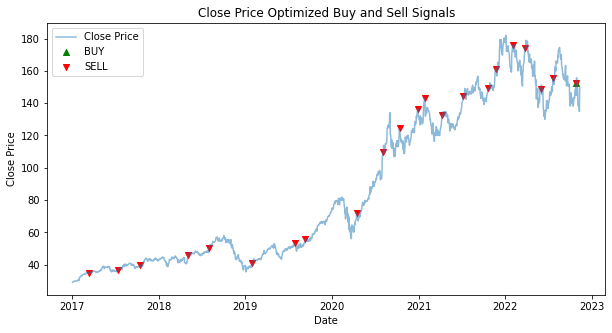

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df.index, df["Close"], label = "Close Price", alpha = 0.5)

plt.scatter(decisions_buy["Date"], decisions_buy["Values"], color="green",label="BUY",marker="^",alpha=1)
plt.scatter(decisions_sell["Date"], decisions_sell["Values"],color="red",label="SELL",marker="v",alpha=1)

plt.title("Close Price Optimized Buy and Sell Signals")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc = "upper left")